## Лабораторная работа по DL

### Часть 2. Almost Shakespeare 
Генерация текста с помощью нейронных сетей. 

Обучить нейронную сеть на сонетах Шекспира и нейросетью написать свой сонет.

Генерация текста обычно включает в себя следующие шаги:
    
1. Загрузка данных.
2. Создание словарей слов/символов.
3. Препроцессинг данных.
4. Обучение модели (нейросети).
5. Генерация нового текста.


#### Часть 1. Предобработка данных

Для начала загрузим данные. Файл с сонетами Шекспира доступен по [ссылке](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). Кроме того, он находится рядом с этим ноутбуком (`sonnetes.txt`).

Базовая предобработка уже сделана: текст состоит непосредственно из поэм Шекспира и названий/номеров глав, все техническая информация удалена.

In [1]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

Так как в этот раз мы хотим научиться предсказывать текст, понизим сложность задачи и приведем текст к нижнему регистру.

В настоящий момент переменная `text` представляет собой список из строк. Объедините все строки в одну и приведите к нижнему регистру. 

In [2]:
# Объедините все строки в одну и приведите к нижнему регистру.
# Результат запишите в переменную text.

# Your great code here
import string

text = ''.join(text)
text = text.lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('Отлично!')

Отлично!


Выделите множество всех символов, с которыми нам довелось встретиться в переменную `tokens`.

In [3]:
tokens = sorted(set(text))

Постройте словарь `token_to_idx` вида <символ>: <индекс> и словарь `idx_to_token` вида <индекс>: <символ>.

In [4]:
# словарь вида <символ>:<индекс>
# словарь вида <индекс>:<символ>
token_to_id = {token:index for index,token in enumerate(tokens)}
id_to_token = tokens

*Комментарий: т.к. у нас всего 38 различных токенов, в этот раз воспользуемся one-hot encoding'ом.*


## Построение модели.

Теперь наша задача - создать и обучить рекуррентную нейронную сеть, которая сможет генерировать что-то похожее на поэзию Шекспира.

Для начала воспользуемся классической RNN, аналогичной построенной на семинаре. 

In [5]:
# Your modified code from class here
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


def to_matrix(text, batch_size=32):
    matrix = []
    seq_len = int(len(text) / batch_size)
      
    for i in range(0, seq_len * batch_size, seq_len):
        matrix.append([token_to_id[j] for j in text[i:i+seq_len]])

    return torch.tensor(matrix, dtype=torch.long)



class CharRNN(nn.Module):
   
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn = nn.RNN(embedding_size, rnn_num_units, batch_first = True)
        self.linear = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        out, h_next = self.rnn(x_emb, h_prev)
        
        logits = self.linear(out)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return torch.zeros(1, batch_size, self.num_units, requires_grad = True)

In [6]:
batch_size = 32
epochs = 10

In [7]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNN()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

Постройте график функции потерь в зависимости от номера эпохи.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

batch_ix = to_matrix(text, batch_size)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

for i in range(100):
   
    hidden_state = char_rnn.initial_state(batch_size)
    fluff, logp_seq = char_rnn(batch_ix, hidden_state)

    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.item())
    
    clear_output(True)
    plt.plot(history,label='loss')
    plt.legend()
    plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

<Figure size 640x480 with 1 Axes>

In [9]:
loss

tensor(2.5415, grad_fn=<NegBackward>)

In [10]:
# Пример сгенерированного текста. Функция `generate_text` отсутствует в коде выше.
# print(generate_text(length=500, temperature=0.2))

In [11]:
def generate_text(char_rnn, max_length, seed_phrase = ' ',  temperature = 1.0):
  
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.long)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, :, i], hid_state)

    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:,:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0].ravel()
        
        next_ix = np.random.choice(len(tokens),p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.long)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [12]:
generate_text(char_rnn, max_length = 500, temperature = 0.2)

' boere the thee the the the the the bean the than the the the  the the the the the the the the the  oo the the the the the the the thee the the the the wit mo the the fo  oou the the bo ane whe  anese the the the the the the the the the the the the the the the the thes  ane sore so ther the the the there than so the thet so the  ao the the the the the se the the the the the the se ther the the  and the the the se oore the the the the the the these thet the there the thet thae  ane more the the t'

### Более поэтичная модель

Теперь давайте воспользуемся LSTM слоем вместо классической RNN и сравним результаты.

Снова постройте график функции потерь от числа эпох. Стал ли финальный loss лучше?

In [13]:
class CharLSTM(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=16, num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = num_units
        self.embedding = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, num_units, batch_first=True)
        self.linear = nn.Linear(num_units, num_tokens)
        
    def forward(self, x, hidden_state):
        x_emb = self.embedding(x)
        out, hidden_state = self.lstm(x_emb, hidden_state)
        logits = self.linear(out)
        return hidden_state, F.log_softmax(logits, dim=-1)
    
    def initial_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.num_units, requires_grad=True),
                torch.zeros(1, batch_size, self.num_units, requires_grad=True))

In [14]:
char_lstm = CharLSTM()

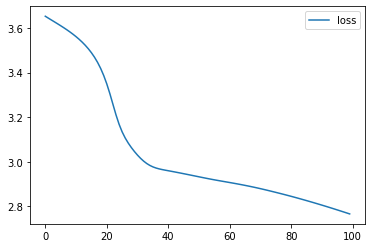

In [15]:
batch_ix = to_matrix(text, batch_size)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

opt = torch.optim.Adam(char_lstm.parameters())
history = []

for i in range(100):
   
    hidden_state = tuple([hs for hs in char_lstm.initial_state(batch_size)])
    fluff, logp_seq = char_lstm(batch_ix, hidden_state)

    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())

    clear_output(True)
    plt.plot(history,label='loss')
    plt.legend()
    plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Сгенерируйте текст с помощью обученной сети для различных значений параметра `temperature`: `[0.1, 0.2, 0.5, 1.0, 2.0]` ("температуры" при генерации). Оцените результаты визуально, попробуйте их проинтерпретировать.

In [16]:
# Text generation with different tempearature values here
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print('temperature = ', t, '\n', generate_text(char_lstm, max_length = 500, temperature = t), '\n -------------------- \n')

temperature =  0.1 
  the  th the  t th  t   th  th th  th th  th  th th  th  th  the  th   the  th  the  th  a th  th  th  th  th  the t  th  th  th th   th  the  th  th  th   th th   the t  th   th  th t th  th t  the  th  th  the  t th  th th  th   the   th  th  th t  th  th th  th  th th  the th  th  th t  th  the t  t t  th  th  th  th  th  th t  th th   the th   th th  th  th   th  th t th th   th t  the  th th   th th  th t  th  th th  th  th   th th  t th  th  th   th th  th t  th  th th  th  th  th  the  th 
 -------------------- 

temperature =  0.2 
  bthe t  th s th th  t  th t  th th th   th t  th t   the th t  a  th  to  th  th th t  i t  the  t  th  the  th t  t  the the  t  the th  th a the  th thet   th  t  th  te  rea t   t   th th  thee   ahe th  th  t  th  th  t th   s t  the  t  the  th  t th  th    t th  th  t th  th   t  ne th   th  th t s te  to t  t  t   the th t  t  th  o th   th  th th th  ee  t t  t te  a t    th  a the  the th th  t  the  th  t th th  th th

In [17]:
token_to_id

{'\n': 0,
 ' ': 1,
 '!': 2,
 "'": 3,
 '(': 4,
 ')': 5,
 ',': 6,
 '-': 7,
 '.': 8,
 ':': 9,
 ';': 10,
 '?': 11,
 'a': 12,
 'b': 13,
 'c': 14,
 'd': 15,
 'e': 16,
 'f': 17,
 'g': 18,
 'h': 19,
 'i': 20,
 'j': 21,
 'k': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'q': 28,
 'r': 29,
 's': 30,
 't': 31,
 'u': 32,
 'v': 33,
 'w': 34,
 'x': 35,
 'y': 36,
 'z': 37}

Здесь можно оставить свои рассуждения касательно интерпретации результатов.

Чем выше температура, тем более случайный набор текста мы получаем. При этом на низких температурах весь сгенерированный текст состоит буквально из нескольких слов. Вообще интересно получается, мне понравилось. Надо было раньше начинать лабу)

#### Сохранение и загрузка модели

Сохраните обученную модель на диск, затем загрузите ее и сгенерируйте текст. Примеры доступны по [ссылке](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [18]:
# Saving and loading code here
torch.save(char_lstm.state_dict(), 'Shakespeare_lstm.pt')
char_lstm = CharLSTM()
char_lstm.load_state_dict(torch.load('Shakespeare_lstm.pt'))
char_lstm.eval()

print(generate_text(char_lstm, max_length=600, temperature=0.66))

 awuet lln
 w  fai iuraond (oit  tog it  mssss bsith 
 n ,
  rvo ui oo t st sgho mtrt s  mtooahe teai t  t'tae  sget t,  wo e hno toh ue
h  anos   to lee, s   etues  ihdiwh l cet syt  ti um oorni so no edha eeinr, ress the b nth  mt d t
 t  to thle yto  a
lu thga tioeto
 he eti    mu,oer eni eees  ri m  to a
   tix  th
  is witid  e ndo !esef d amshae  thei  iene  atn t t a mtii l gnnt to  snis ti fis rs 
o  te s dn tbfh  lgs rie th te!ao theoheyn a thea ls tolaea tu t  heated  tho t o ithe h s ue the t tnhe te ai cwo n t rhot t' a  th oare n tagtehro ea awefip  ten  od botr    sa t s ii poue 
